In [16]:
import joblib

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
random_state = 77
current_year = 2023

In [3]:
df = pd.read_csv('phone_data.csv')
df.head()

,title,source,price,ram_gb,memmory_gb,main_cam_mp,front_cam_mp,dual_cam,is_iphone_and_age
0,მობილური ტელეფონი apple iphone 14 pro max 256g...,be.ge,3899,6.0,256.0,48.0,12.0,1,1.0
1,მობილური ტელეფონი apple iphone 14 pro max 128g...,be.ge,3599,6.0,128.0,48.0,12.0,1,1.0
2,მობილური ტელეფონი apple iphone 13 128gb midnight,be.ge,2150,4.0,128.0,12.0,12.0,1,2.0
3,მობილური ტელეფონი apple iphone 14 pro max 128g...,be.ge,3599,6.0,128.0,48.0,12.0,1,1.0
4,მობილური ტელეფონი apple iphone 14 pro max 128g...,be.ge,3599,6.0,128.0,48.0,12.0,1,1.0


In [4]:
df.describe()

,price,ram_gb,memmory_gb,main_cam_mp,front_cam_mp,dual_cam,is_iphone_and_age
count,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000
mean,1390.183347,5.893515,157.823058,47.990152,12.662930,0.860689,-0.383507
std,1234.274660,2.419677,118.919420,36.923708,7.952164,0.346410,1.185956
min,200.000000,2.000000,1.000000,8.000000,2.000000,0.000000,-1.000000
25%,408.000000,4.000000,64.000000,13.000000,8.000000,1.000000,-1.000000
50%,849.000000,6.000000,128.000000,50.000000,12.000000,1.000000,-1.000000
75%,2149.000000,8.000000,256.000000,50.000000,13.000000,1.000000,-1.000000
max,5699.000000,16.000000,1000.000000,200.000000,50.000000,1.000000,4.000000


In [5]:
X = df[['ram_gb', 'memmory_gb', 'main_cam_mp', 'front_cam_mp', 'dual_cam', 'is_iphone_and_age']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

In [6]:
pipe = Pipeline([
    ('imputer',KNNImputer()),
    ('model', RandomForestRegressor(criterion='squared_error', random_state=random_state))
    
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__max_depth': [None, 10, 15, 20, 30],
    'model__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', verbose=1)

In [7]:
%%time
grid_search.fit(X_train, y_train)
print(f'best_params: {grid_search.best_params_}')
print(f'cross_val_score: {(-grid_search.best_score_) ** 0.5:0.4f}')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
best_params: {'model__bootstrap': False, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
cross_val_score: 220.2669
CPU times: total: 2min 6s
Wall time: 2min 6s


In [8]:
pred_train = grid_search.predict(X_train)
pred_test = grid_search.predict(X_test)

train_error = pred_train - y_train
test_error = pred_test - y_test

rmse_train = mean_squared_error(y_train, pred_train) ** 0.5
rmse_test = mean_squared_error(y_test, pred_test) ** 0.5
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)

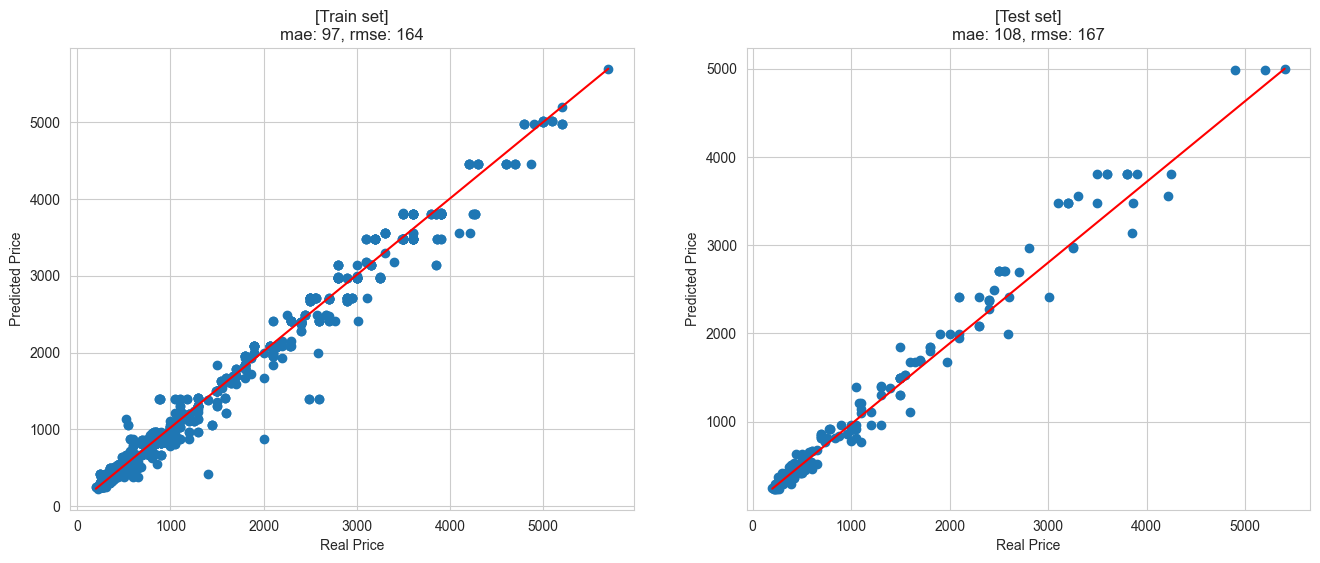

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot([y_train.min(), y_train.max()], [pred_train.min(), pred_train.max()], c='r')
ax[1].plot([y_test.min(), y_test.max()], [pred_test.min(), pred_test.max()], c='r')

ax[0].scatter(y_train, pred_train)
ax[1].scatter(y_test, pred_test)

ax[0].set_xlabel('Real Price')
ax[1].set_xlabel('Real Price')

ax[0].set_ylabel('Predicted Price')
ax[1].set_ylabel('Predicted Price')

ax[0].set_title(f'[Train set]\nmae: {mae_train:0.0f}, rmse: {rmse_train:0.0f}');
ax[1].set_title(f'[Test set]\nmae: {mae_test:0.0f}, rmse: {rmse_test:0.0f}');

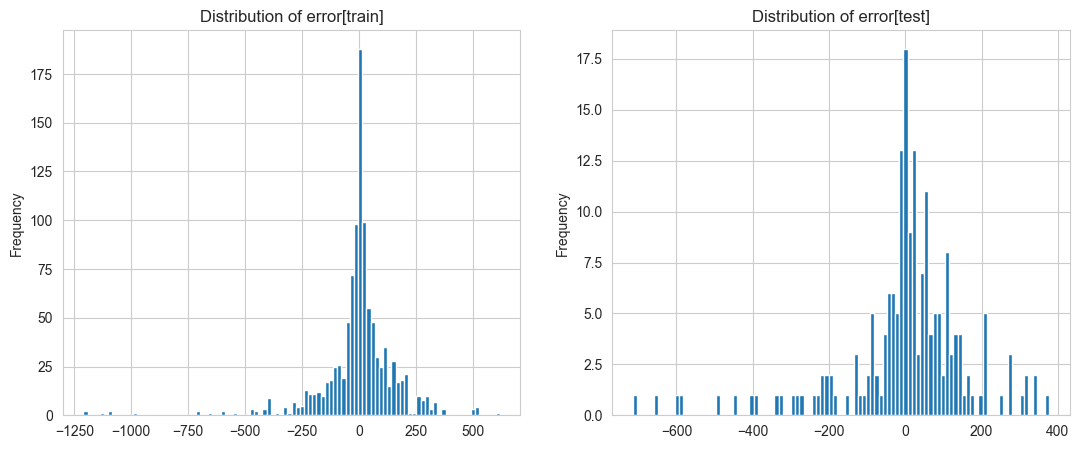

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
train_error.plot(kind='hist', bins=100, ax=ax[0])
test_error.plot(kind='hist', bins=100, ax=ax[1])
ax[0].set_title('Distribution of error[train]');
ax[1].set_title('Distribution of error[test]');

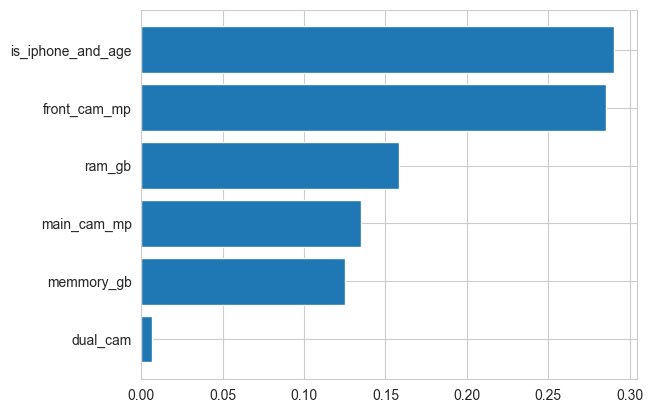

In [11]:
forplot = (pd.DataFrame({'feature':X_train.columns, 'importance':grid_search.best_estimator_[-1].feature_importances_}).
          sort_values(by='importance'))
plt.barh(y=forplot['feature'], width=forplot['importance']);

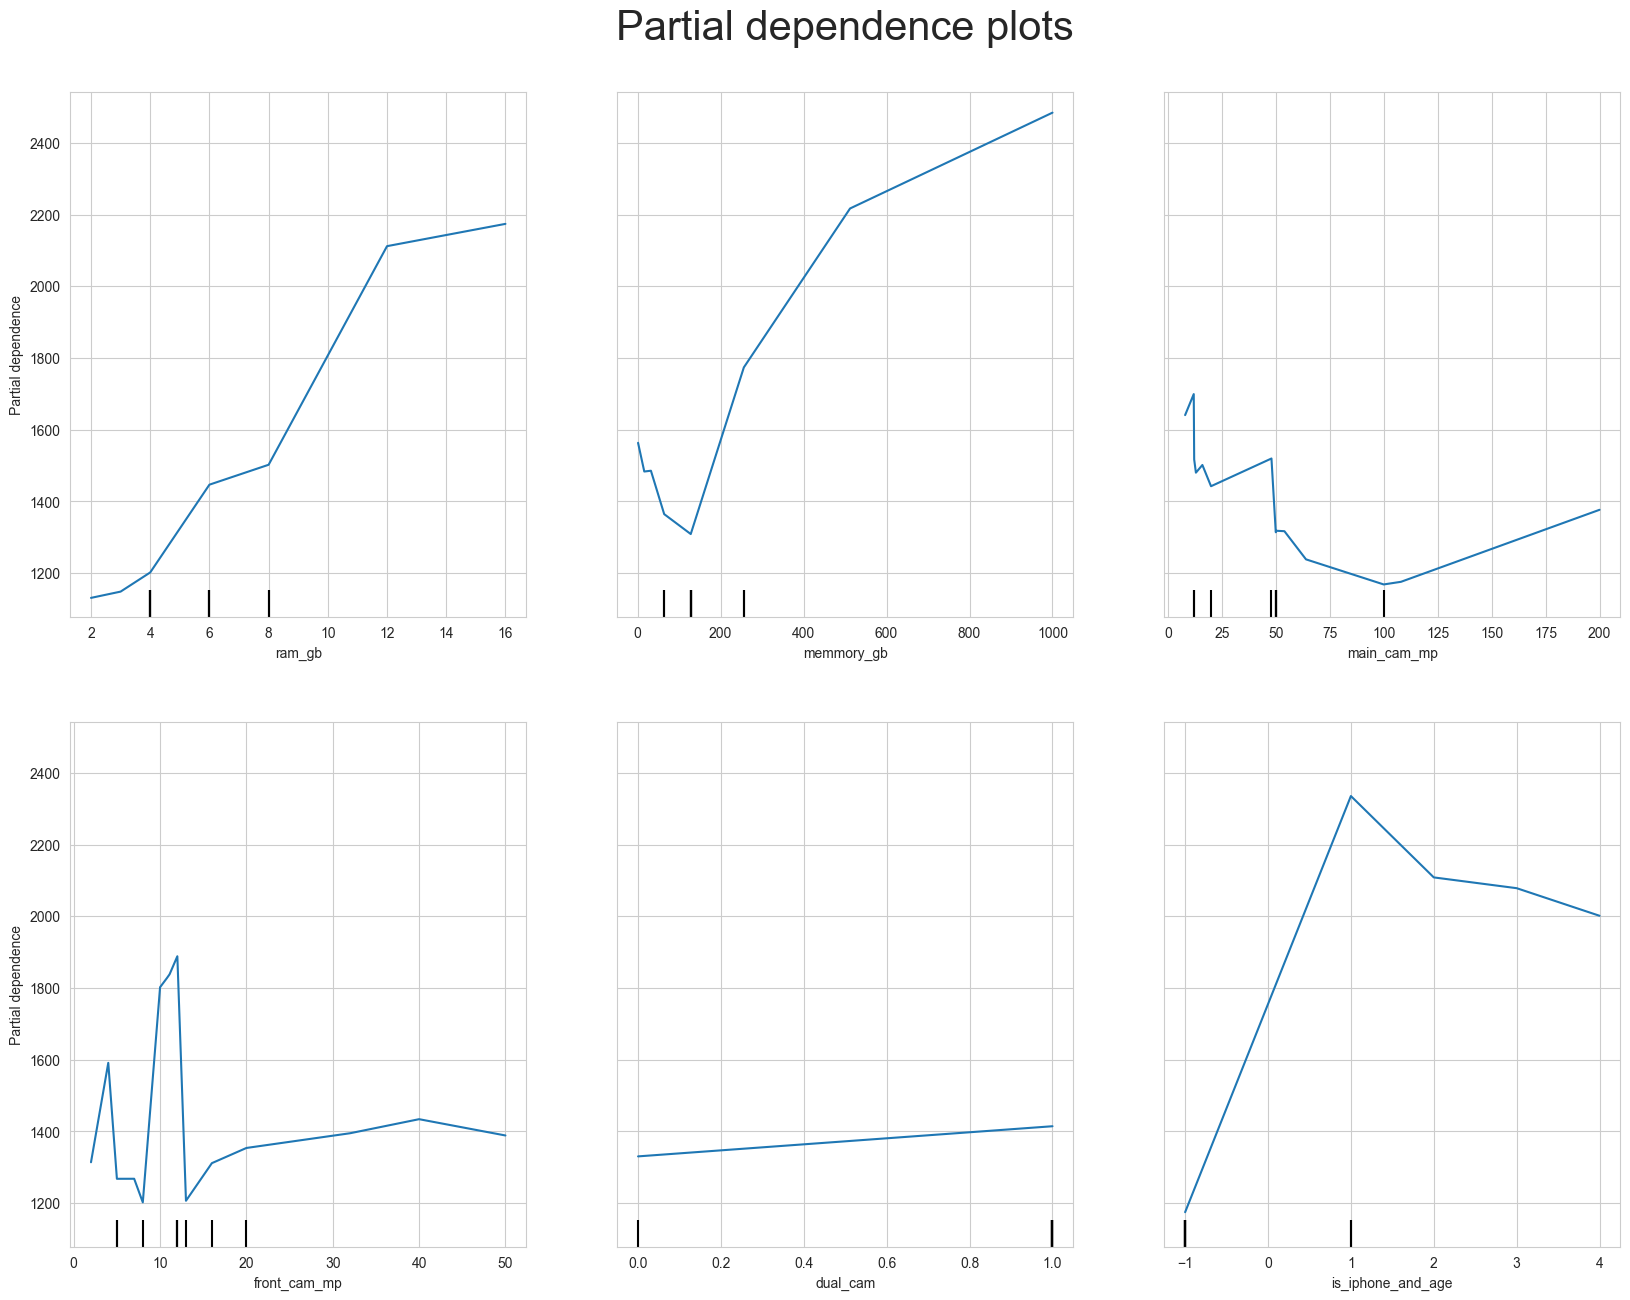

In [12]:
fig, ax = plt.subplots(figsize=(20, 15))
PartialDependenceDisplay.from_estimator(grid_search, X_train, features=X_train.columns, ax=ax)
ax.set_title('Partial dependence plots\n', fontsize=30);

# Add transformer for Silknet data

In [17]:
class SilknetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        current_year = 2023
        X['is_iphone_and_age'] = (current_year - X['year'].astype(float))*(X['os_name'] == 'iOS')
        X['memmory_gb'] = X['internal_memory_size'].astype(float)/1000
        X['ram_gb'] = X['ram_capacity'].str.extract(r'(\d+)\sMiB').astype(float)/1024
        X['main_cam_mp'] = X['camera_resolution'].astype(float)
        X['front_cam_mp'] = X['sec_cam_hor_resolution'].astype(float) * X['sec_cam_ver_resolution'].astype(float)/1_000_000
        X['dual_cam'] = X['dual_camera'].map({'Yes':1, 'No':0})
        X = X[['ram_gb', 'memmory_gb', 'main_cam_mp', 'front_cam_mp', 'dual_cam', 'is_iphone_and_age']]
        return X

In [18]:
pipeline = Pipeline([
    ('preprocessor', SilknetPreprocessor()),
    ('best_pipe',grid_search.best_estimator_)
])

In [19]:
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']